# Übung 2: Machine Learning
Fink Lucas, 26.04.2025

#### Packages und Daten importieren

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge


dirpath = './Daten/'
bike_rental = pd.read_csv(dirpath + 'Bike_rental_modified.csv')

## 1) Training linearer Modelle

In [5]:
columns = ['intday', 'season', 'yr', 'mnth', 'holiday',
       'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum',
       'windspeed']

X = bike_rental[columns]  # Trainingsfeatures
y = bike_rental['cnt']    # Trainingslabels

In [6]:
n_valid = int(0.8 * X.shape[0])

X_train = X[:n_valid]
X_valid = X[n_valid:]
y_train = y[:n_valid]
y_valid = y[n_valid:]

In [7]:
enc_features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday']
num_features = ['weathersit', 'temp', 'atemp', 'hum', 'windspeed']

enc = OneHotEncoder(sparse_output=False, handle_unknown= 'ignore')  # macht aus einem Feature zB 7 für Wochentage

X_train_enc = enc.fit_transform(X_train[enc_features]) # transformiert die Daten 0-6 Wochentage 
X_train_enc = pd.DataFrame(X_train_enc, columns = enc.get_feature_names_out(enc_features))

X_valid_enc = enc.transform(X_valid[enc_features])
X_valid_enc = pd.DataFrame(X_valid_enc, columns = enc.get_feature_names_out(enc_features))

scaler = MaxAbsScaler()     # dividiert durch den größten Betrag um einen Wert zwischen 0 und 1 zu bekommen
X_train_scale = scaler.fit_transform(X_train[num_features])
X_train_scale = pd.DataFrame(X_train_scale, columns = num_features)

X_valid_scale = scaler.transform(X_valid[num_features])
X_valid_scale = pd.DataFrame(X_valid_scale, columns = num_features)


X_train_final = pd.concat((X_train_enc, X_train_scale), axis=1)
X_valid_final = pd.concat((X_valid_enc, X_valid_scale), axis=1)

### Lineares Modell: Methode -> Ridge
Es wird das Ridge Regressions Modell initialisiert. Es wird ein Suchgitter für den Hyperparameter 'alpha' definiert.
* Alpha steuert die Stärke der Regularisierung
* Modell wird mit 5-facher Kreuzvalidierung(cv) getestet 

In [8]:
ridge_model = Ridge()
ridge_param_grid = {'alpha':[0, 1e-6, 1e-5, 0.0001, 0.001 ,0.01, 0.1, 1, 10, 100]}
ridge_search_cv = GridSearchCV(ridge_model, ridge_param_grid, cv = 5, verbose = 3,scoring = 'neg_mean_squared_error', return_train_score= True)
ridge_search_cv.fit(X_train_final, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END alpha=0;, score=(train=-442194.160, test=-337627.955) total time=   0.0s
[CV 2/5] END alpha=0;, score=(train=-328759.745, test=-144110474447138467519134013262397440.000) total time=   0.0s
[CV 3/5] END alpha=0;, score=(train=-271077.229, test=-13954783678081718645253271785046016.000) total time=   0.0s
[CV 4/5] END alpha=0;, score=(train=-318901.111, test=-31445631234164504704247984713367552.000) total time=   0.0s
[CV 5/5] END alpha=0;, score=(train=-320342.183, test=-389640277203325727726813969383424.000) total time=   0.0s
[CV 1/5] END alpha=1e-06;, score=(train=-352940.304, test=-380414.257) total time=   0.0s
[CV 2/5] END alpha=1e-06;, score=(train=-318361.232, test=-1481671.218) total time=   0.0s
[CV 3/5] END alpha=1e-06;, score=(train=-262328.795, test=-789779.390) total time=   0.0s
[CV 4/5] END alpha=1e-06;, score=(train=-310804.935, test=-572262.018) total time=   0.0s
[CV 5/5] END alpha=1e-06;, score=

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=3)

### Lineares Modell: Methode -> Lasso

In [17]:
lasso_model = Lasso(max_iter=50000)
lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
lasso_search = GridSearchCV(lasso_model, lasso_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
lasso_search.fit(X_train_final, y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ........................................alpha=0.001; total time=   0.1s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END ........................................alpha=0.001; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ........................................

GridSearchCV(cv=5, estimator=Lasso(max_iter=50000),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10]},
             scoring='neg_mean_squared_error', verbose=2)

### Lineares Modell: Methode -> KernelRidge

In [25]:
kernelRidge_model = KernelRidge(kernel='rbf')
kernelRidge_param_grid = {
    'alpha': [0, 1e-6, 1e-5, 0.0001, 0.001 ,0.01, 0.1, 1, 10, 100],
    'gamma': [0, 1e-6, 1e-5, 0.0001, 0.001 ,0.01, 0.1, 1, 10, 100]
}
kernelRidge_search = GridSearchCV(kernelRidge_model, kernelRidge_param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
kernelRidge_search.fit(X_train_final, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ...................................alpha=0, gamma=0; total time=   0.0s
[CV] END ...................................alpha=0, gamma=0; total time=   0.0s
[CV] END ...................................alpha=0, gamma=0; total time=   0.0s
[CV] END ...................................alpha=0, gamma=0; total time=   0.0s
[CV] END ...................................alpha=0, gamma=0; total time=   0.0s
[CV] END ...............................alpha=0, gamma=1e-06; total time=   0.0s
[CV] END ...............................alpha=0, gamma=1e-06; total time=   0.0s
[CV] END ...............................alpha=0, gamma=1e-06; total time=   0.0s
[CV] END ...............................alpha=0, gamma=1e-06; total time=   0.0s


c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual prob

[CV] END ...............................alpha=0, gamma=1e-06; total time=   0.0s
[CV] END ...............................alpha=0, gamma=1e-05; total time=   0.0s
[CV] END ...............................alpha=0, gamma=1e-05; total time=   0.0s
[CV] END ...............................alpha=0, gamma=1e-05; total time=   0.0s
[CV] END ...............................alpha=0, gamma=1e-05; total time=   0.0s
[CV] END ...............................alpha=0, gamma=1e-05; total time=   0.0s
[CV] END ..............................alpha=0, gamma=0.0001; total time=   0.0s
[CV] END ..............................alpha=0, gamma=0.0001; total time=   0.0s
[CV] END ..............................alpha=0, gamma=0.0001; total time=   0.0s
[CV] END ..............................alpha=0, gamma=0.0001; total time=   0.0s
[CV] END ..............................alpha=0, gamma=0.0001; total time=   0.0s
[CV] END ...............................alpha=0, gamma=0.001; total time=   0.0s
[CV] END ...................

c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
c:\workspaces\EinführungMaschinellesLernen\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:254: UserWarning: Singular matrix in solving dual prob

[CV] END ................................alpha=0, gamma=0.01; total time=   0.0s
[CV] END .................................alpha=0, gamma=0.1; total time=   0.0s
[CV] END .................................alpha=0, gamma=0.1; total time=   0.0s
[CV] END .................................alpha=0, gamma=0.1; total time=   0.0s
[CV] END .................................alpha=0, gamma=0.1; total time=   0.0s
[CV] END .................................alpha=0, gamma=0.1; total time=   0.0s
[CV] END ...................................alpha=0, gamma=1; total time=   0.0s
[CV] END ...................................alpha=0, gamma=1; total time=   0.0s
[CV] END ...................................alpha=0, gamma=1; total time=   0.0s
[CV] END ...................................alpha=0, gamma=1; total time=   0.0s
[CV] END ...................................alpha=0, gamma=1; total time=   0.0s
[CV] END ..................................alpha=0, gamma=10; total time=   0.0s
[CV] END ...................

GridSearchCV(cv=5, estimator=KernelRidge(kernel='rbf'),
             param_grid={'alpha': [0, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100],
                         'gamma': [0, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                   10, 100]},
             scoring='neg_mean_squared_error', verbose=2)

Ausgabe des besten Hyperparameter (niedrigster MSE)

In [ ]:
ridge_search_cv.best_params_

{'alpha': 1}

In [13]:
lasso_search.best_params_

{'alpha': 1}

In [27]:
kernelRidge_search.best_params_

{'alpha': 0.001, 'gamma': 0.001}

Alle Ergebnisse der Kreuzvalidierung für die Visualisierung/Analyse speichern

In [28]:
ridge_cv_results = pd.DataFrame(ridge_search_cv.cv_results_)
lasso_cv_results = pd.DataFrame(lasso_search.cv_results_)
kernelRidge_cv_results = pd.DataFrame(kernelRidge_search.cv_results_)


## 2) Grafische Darstellung, Over und Underfitting

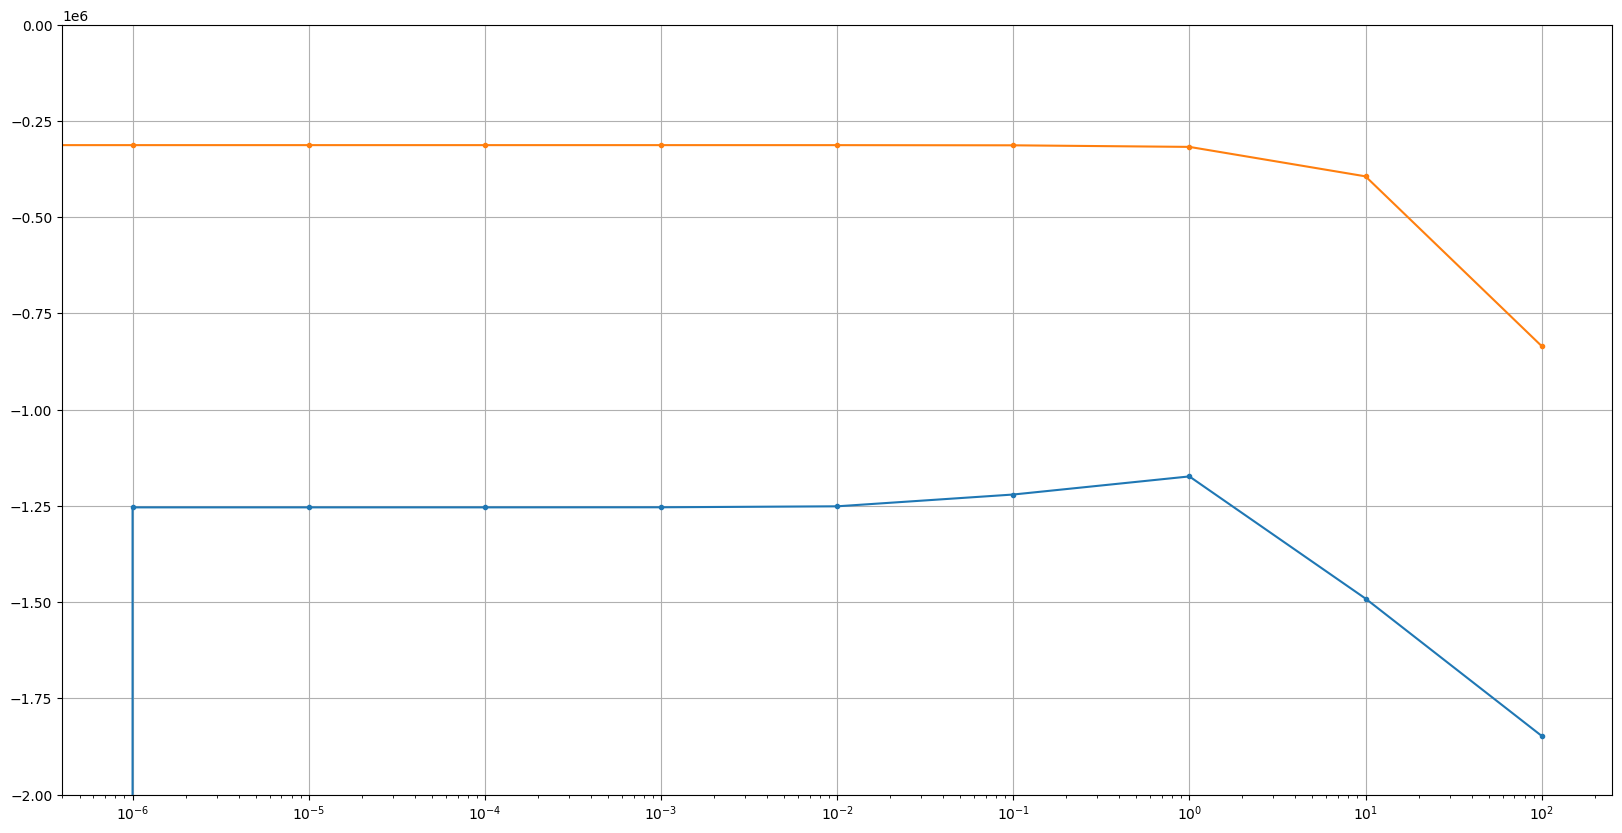

In [21]:
fig, ax = plt.subplots(1, figsize = (20,10))
ax.plot(ridge_param_grid['alpha'], ridge_cv_results['mean_test_score'], marker = '.')
ax.plot(ridge_param_grid['alpha'], ridge_cv_results['mean_train_score'], marker = '.')

ax.set_ylim(-2e6, 0)
ax.set_xscale('log')
ax.grid()

KeyError: 'mean_train_score'

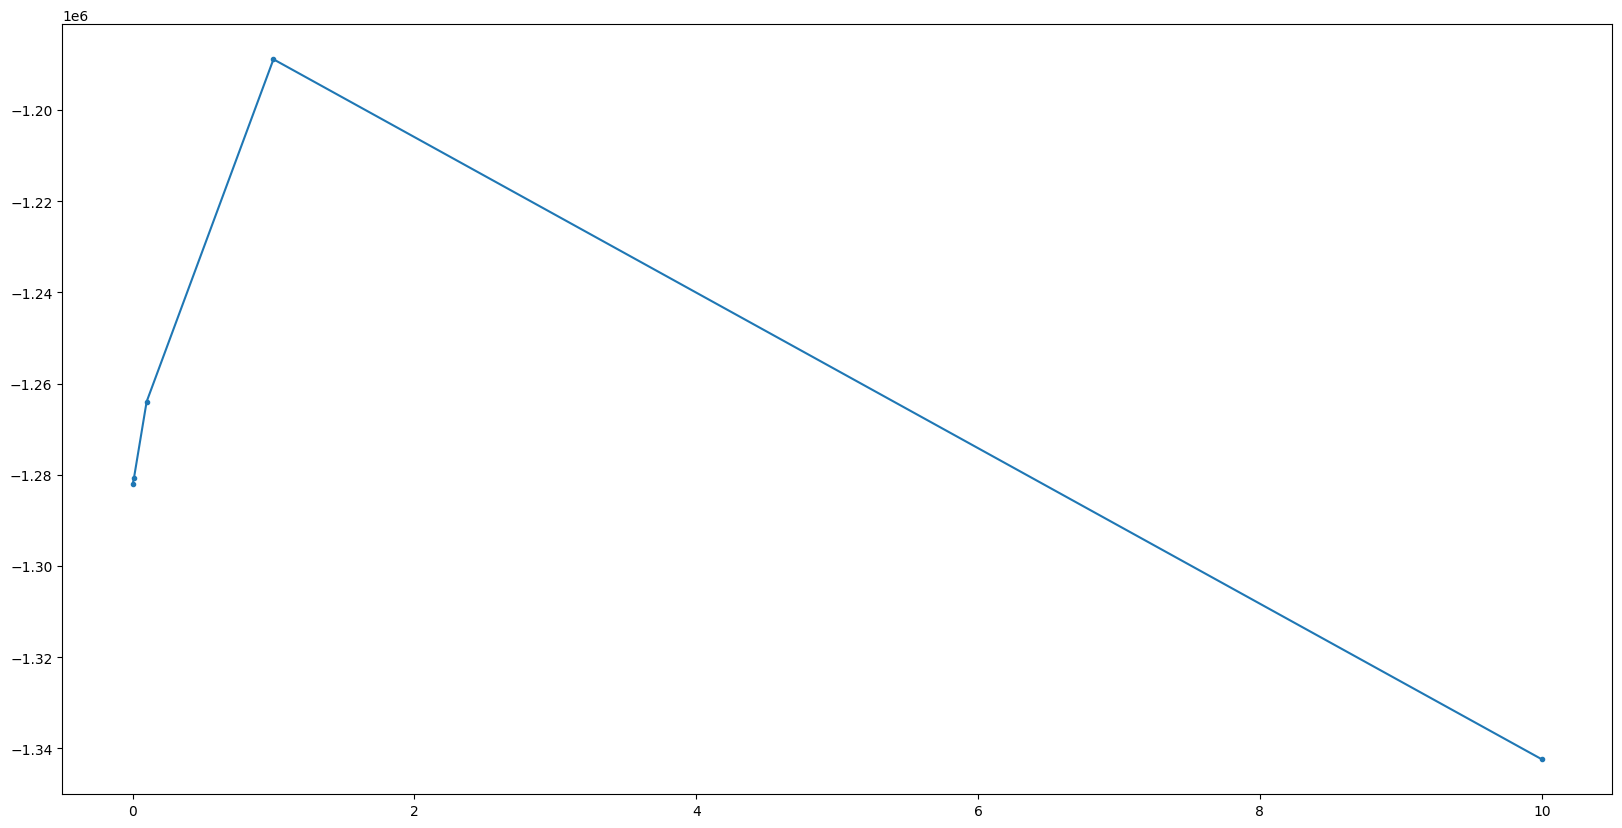

In [22]:
fig, ax = plt.subplots(1, figsize = (20,10))
ax.plot(lasso_param_grid['alpha'], lasso_cv_results['mean_test_score'], marker = '.')
ax.plot(lasso_param_grid['alpha'], lasso_cv_results['mean_train_score'], marker = '.')

ax.set_ylim(-2e6, 0)
ax.set_xscale('log')
ax.grid()

ValueError: x and y must have same first dimension, but have shapes (10,) and (100,)

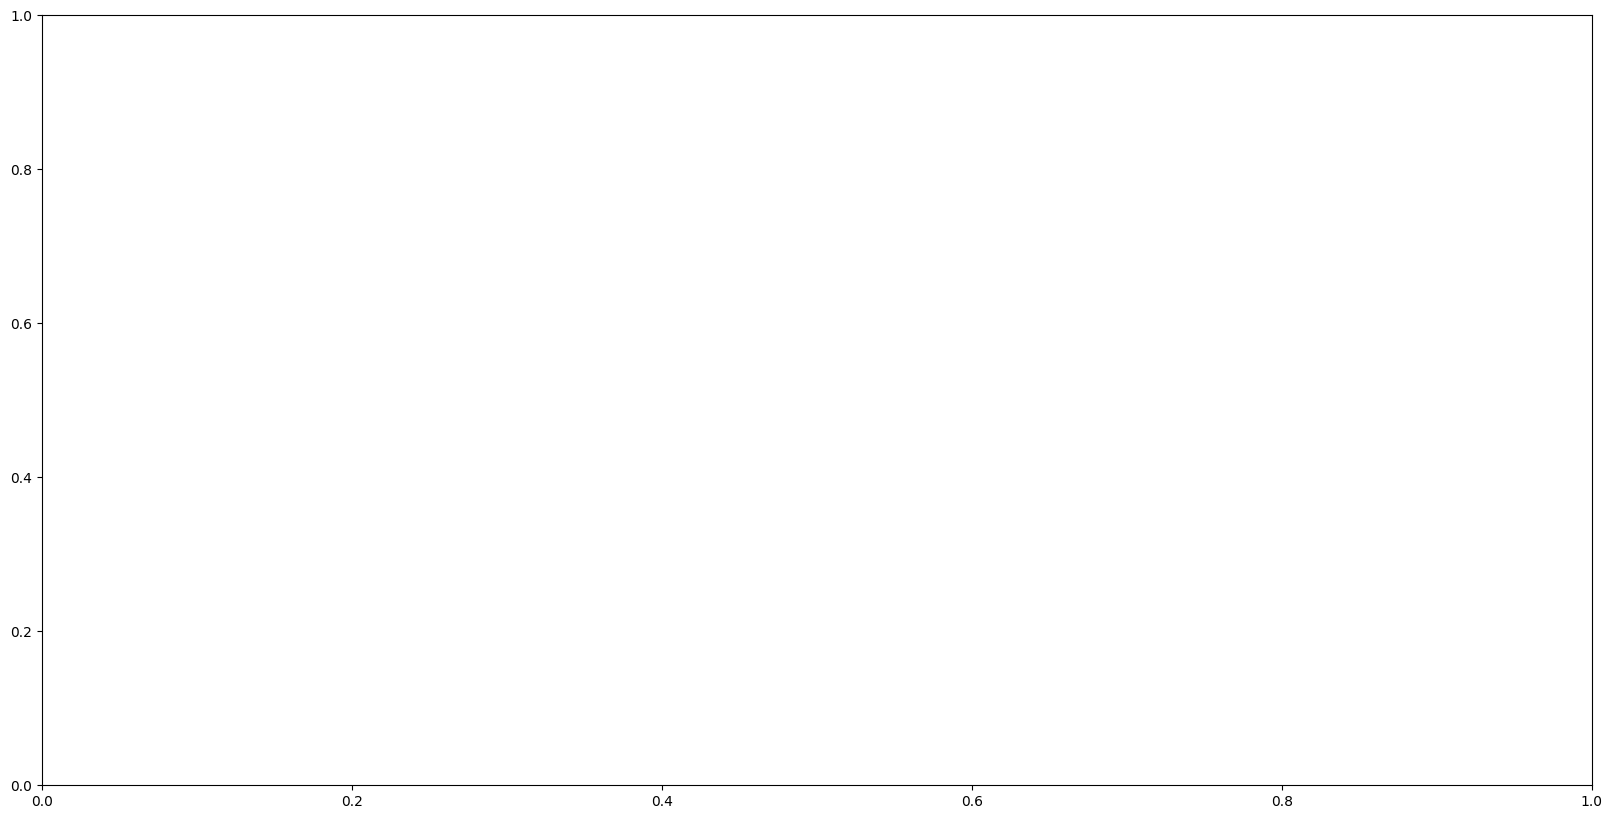

In [ ]:
fig, ax = plt.subplots(1, figsize = (20,10))
ax.plot(kernelRidge_param_grid['alpha'], kernelRidge_cv_results['mean_test_score'], marker = '.')
ax.plot(kernelRidge_param_grid['alpha'], kernelRidge_cv_results['mean_train_score'], marker = '.')

ax.set_ylim(-2e6, 0)
ax.set_xscale('log')
ax.grid()